# 1. Introduction

Fichier qui permet d'exporter les differentes donnees necessaires a la diffusion des graphs sur le web, via quelques fonctions qui les retraitent pour correspondre aux filtres attendus.

In [2]:
import gen_dataset_810 as mod_810fr
import matplotlib.pyplot as plt
# importer datetime pour typer les donnees de dates des chaines et des videos
import datetime
import pandas as pd

# Définition des dates limites pour les filtres de https://s01.810.fr
datemin_2022 = datetime.datetime(2022, 1, 1, 0, 0, 0)
datemax_2022 = datetime.datetime(2022, 4, 1, 0, 0, 0)
datemin_2021 = datetime.datetime(2021, 1, 1, 0, 0, 0)

# Récupération des fichiers générés à partir des API YouTube
folder_candidats = './data_sources/stats_videos/2022_03_08/'
# Création d'un datafram qui agrège les fichiers
dt_candidats = mod_810fr.mb_ds()
# Génération d'un dataframe de vidéos et d'un dataframe de chaîne (exemple dans les blocs qui suivent)
videos_candidats_toutes, chaines_candidats_toutes  = dt_candidats.get_full_data_candidat(folder = folder_candidats)

# Création du dataframe de vidéos, spécial 2022
videos_candidats_2022 = videos_candidats_toutes[videos_candidats_toutes['dateVideo'] > datemin_2022]
videos_candidats_2022 = videos_candidats_2022[videos_candidats_2022['dateVideo'] < datemax_2022]

# Création du dataframe de vidéos, spécial 2021
videos_candidats_2021 = videos_candidats_toutes[videos_candidats_toutes['dateVideo'] > datemin_2021]
videos_candidats_2021 = videos_candidats_2021[videos_candidats_2021['dateVideo'] < datemin_2022]


dossier_output = './data_output/'
toptagsfolder_json = 'top-tags-json/'
activityfolder_json = 'activity-json/'
toptagsfolder_csv = 'top-tags-csv/'
activityfolder_csv = 'activity-csv/'

Imported 32 channel data


### 1.1 Affichage de la première ligne et du nombre de lignes totales


In [3]:
videos_candidats_toutes.head(1)

,dateRqt,candidat,parti,courant,chaine,titreVideo,vid_id,dateVideo,liste_tags,livebroadcast,vuesVideo,likesVideo,dislikesVideo,favVideo,comzVideo,dureeVideo
0,2022/03/08,Alexandre Langlois,Refondation 2022,divers,Langlois Alexandre,Procès #Benalla jour 6 : Jardin des plantes 2è...,8ybnjmL7Jbw,2021-09-24 09:06:06,[#Benalla #Macron #France #Présidentielles #La...,none,2971,160,0,0,5,0 days 00:08:06


In [4]:
videos_candidats_toutes.shape

(4297, 16)

In [5]:
chaines_candidats_toutes.head(1)

,dateRqt,candidat,parti,courant,chaine,dateCreationChaine,pays,categorieschaine,vuesChaine,abonnesChaine,nbVideosChaine
0,2022/03/08,Alexandre Langlois,Refondation 2022,divers,Langlois Alexandre,2017-10-11,FR,"[https://en.wikipedia.org/wiki/Society, https:...",16062,703,16


In [6]:
chaines_candidats_toutes.shape

(32, 11)

Maintenant que la liste officielle des candidats et candidates a été publiée, nous allons limiter notre traitement par courant, aux chaînes associées à la campagne de chaque candidat et candidate officel(le)

liste_candidats = ['Eric Zemmour', 'Avec vous', 'Jean-Luc Mélenchon', 'Valérie Pécresse', 'Yannick Jadot', 'Anne Hidalgo']

In [7]:
videos_candidats_toutes.candidat.unique()

array(['Alexandre Langlois', 'Emmanuel Macron', 'Nathalie Arthaud',
       'Jean-Luc Mélenchon', 'Florian Philippot', 'Anasse Kazib',
       'Charlotte Marchandise', 'Delphine Batho', 'Jacline Mouraud',
       'Jean Lassalle', 'Jean-Frédéric Poisson', 'Denis Payre',
       'Anne Hidalgo', 'Marine Le Pen', 'Valérie Pécresse',
       'Philippe Furlan', 'Gildas Vieira', 'Michel Barnier',
       'Nicolas Dupont-Aignan', 'Eric Piolle', 'Philippe Juvin',
       'Stéphane Tauthui', 'Gérard Filoche', 'Yannick Jadot',
       'Pierre Larrouturou', 'Eric Ciotti', 'Avec vous', 'Martin Rocca',
       'Eric Zemmour'], dtype=object)

In [8]:
liste_chaines_candidats_officiels = ["Nathalie Arthaud", "Jean-Luc Mélenchon", "Jean Lassalle", "Anne Hidalgo", "Marine Le Pen", "Valérie Pécresse", "Nicolas Dupont-Aignan", "Yannick Jadot","Avec vous", "Eric Zemmour"]

# Filtrage du dtf de toutes les vidéos à partir de la liste officielle
boolean_series_globale = videos_candidats_toutes.candidat.isin(liste_chaines_candidats_officiels)
videos_candidats_toutes = videos_candidats_toutes[boolean_series_globale]

# Filtrage des vidéos de l'année 2022
boolean_series_2022 = videos_candidats_2022.candidat.isin(liste_chaines_candidats_officiels)
videos_candidats_2022 = videos_candidats_2022[boolean_series_2022]

# Filtrage des vidéos de l'année 2021
boolean_series_2021 = videos_candidats_2021.candidat.isin(liste_chaines_candidats_officiels)
videos_candidats_2021 = videos_candidats_2021[boolean_series_2021]

# 2. Travail sur l'activité des courants et des candidats

Suivi d'activité : nb vidéos ; likes ; vues ; durée

## 2.1. Définition de nos fonctions de traitement des courants


_N.B : la fonction de durée est déjà codée, mais nous ne l'utilisons pas. Elle donne le nombre de minutes cumulées_

In [9]:
# Fonction utiles pour tous les tableaux ci-apres
# Retourne les videos pour un mois donnees
def vidz_filtree_par_mois(subdtf, mois_moins_un = 13, annee = 2022) : 
    if mois_moins_un == 13 :
        print("mois invalide")
    elif mois_moins_un < 11 :
        videos_du_mois = subdtf[subdtf['dateVideo'] > datetime.datetime(annee, (mois_moins_un+1), 1, 0, 0, 0)]
        videos_du_mois = videos_du_mois[videos_du_mois['dateVideo'] < datetime.datetime(annee, (mois_moins_un+2), 1, 0, 0, 0)]
    else :
        videos_du_mois = subdtf[subdtf['dateVideo'] > datetime.datetime(annee, (mois_moins_un+1), 1, 0, 0, 0)]
        videos_du_mois = videos_du_mois[videos_du_mois['dateVideo'] < datetime.datetime(annee + 1, 1, 1, 0, 0, 0)]
    return videos_du_mois

# Affichage standard : Filtre les données (dataframes) en fonctions des courants associés
def un_dtf_par_courant(subdtf) :
    videos_xd = subdtf[subdtf['courant'] == "Extrême droite"]
    videos_reste = subdtf[subdtf['courant'] != "Extrême droite"]
    videos_xg = subdtf[subdtf['courant'] == "Extrême gauche"]
    videos_reste = videos_reste[videos_reste['courant'] != "Extrême gauche"]
    videos_d = subdtf[subdtf['courant'] == "droite"]
    videos_reste = videos_reste[videos_reste['courant'] != "droite"]
    videos_g = subdtf[subdtf['courant'] == "gauche"]
    videos_reste = videos_reste[videos_reste['courant'] != "gauche"]
    videos_c = subdtf[subdtf['courant'] == "centre"]
    # Ca va sûrement faire rager, mais dans le code, les chaîne d'Emmanuel Macron sont associées au courant "Centre", en tant que dsecendant du Modem
    # Dans nos rapports HTML, on fait généralement référence à la "majorité"
    videos_reste = videos_reste[videos_reste['courant'] != "centre"]
    videos_v = subdtf[subdtf['courant'] == "vert"]
    videos_reste = videos_reste[videos_reste['courant'] != "vert"]
    return videos_xd, videos_xg, videos_d, videos_g, videos_c, videos_v, videos_reste

# Permet de retourner differentes indicateurs relartifs a un DTF
def _valeur_recherchee(indicateur, inputdtf) :
    if indicateur == "duree" :
        resultat = inputdtf["dureeVideo"].sum().total_seconds() / 60
    elif indicateur == 'vues' :
        resultat = inputdtf["vuesVideo"].sum()
    elif indicateur == "likes" :
        resultat = inputdtf["likesVideo"].sum()
    elif indicateur == "comz" :
        resultat = inputdtf['comzVideo'].sum()
    else :
        # Par defaut on retourne le nombre de lignes du DTF, i.e nbVideos
        resultat = inputdtf.shape[0]

    return resultat

# Permet de dumper nos tableaux dans le format attendu pour notre site https://s01.810.fr
def dump_synthese_courants(dtf_synth_courant, nomfichier) :
    liste_a_dumper = []
    for index, row in dtf_synth_courant.iterrows():
        liste_a_dumper.append({"\"Mois\"" : "\""+ str(row["Mois"]) + "\"", "\"Majorité\"" : row["Majorite"], "\"Droite\"" : row["Droite"], "\"Gauche\"" : row["Gauche"], "\"Verts\"" : row["Verts"], "\"Extrême Droite\"" : row["Extreme droite"], "\"Extrême Gauche\"" : row["Extreme gauche"]})

    liste_en_geustr = str(liste_a_dumper)
    liste_en_geustr = liste_en_geustr.replace("'","")
    with open(nomfichier, "w") as text_file:
        text_file.write(liste_en_geustr)

    return

# Affiche un suivi mensuel de l'activité des courants sur YouTube
# i.e : nombre de vidéos postées par mois par les différentes chaînes
#--------------------------------------------------------------------
def ligne_suivi_mensuelle(subdtf_videos, indicateur = "nb videos", annee = 2022) :

    liste_valeurs = []
    for i in range(12) :  
        videos_du_mois = vidz_filtree_par_mois(subdtf = subdtf_videos, mois_moins_un = i, annee=annee)
        valeur_recherchee = _valeur_recherchee(indicateur=indicateur, inputdtf=videos_du_mois)
        liste_valeurs.append(valeur_recherchee)
    # Creation d'un dictionnaire temporaire pour pouvoir transformer mes deux series en dataFrame
    
    return liste_valeurs

# Permet de créer un dataframe global, avec les indicateurs relatifs aux différents courants
# On peut ainsi dumper le dataframe dans un CSV, pour pouvoir l'utiliser dans "datawrapper.de",
#  qui nous permettra d'afficher des graphs web sur le site https://810.fr
def make_synthese_nbvideo_par_courant(dtsource, indicateur = "nb videos", annee = 2022) :
    videos_xd, videos_xg, videos_d, videos_g, videos_c, videos_v, videos_reste = un_dtf_par_courant(subdtf=dtsource)
    # CREATION AXE ABSCISSE
    x_date = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Aout', 'Septembre', 'Octobre', 'Novembre', 'Décembre']

    nomcourant_xd = "Extreme droite"
    lst_res_xd = ligne_suivi_mensuelle(subdtf_videos=videos_xd, indicateur = indicateur, annee = annee)
    nomcourant_xg = "Extreme gauche"
    lst_res_xg = ligne_suivi_mensuelle(subdtf_videos=videos_xg, indicateur = indicateur, annee = annee)
    nomcourant_d = "Droite"
    lst_res_d = ligne_suivi_mensuelle(subdtf_videos=videos_d, indicateur = indicateur, annee = annee)
    nomcourant_g = "Gauche"
    lst_res_g = ligne_suivi_mensuelle(subdtf_videos=videos_g, indicateur = indicateur, annee = annee)
    nomcourant_c = "Majorite"
    lst_res_c = ligne_suivi_mensuelle(subdtf_videos=videos_c, indicateur = indicateur, annee = annee)
    nomcourant_v = "Verts"
    lst_res_v = ligne_suivi_mensuelle(subdtf_videos=videos_v, indicateur = indicateur, annee = annee)


    tmp_d_globalresults = {'Mois' : x_date, nomcourant_xd : lst_res_xd, nomcourant_xg : lst_res_xg, nomcourant_d : lst_res_d, nomcourant_g : lst_res_g, nomcourant_c : lst_res_c, nomcourant_v : lst_res_v}
    dtf_globalresults = pd.DataFrame(tmp_d_globalresults)

    return dtf_globalresults

########################################################################
#   Définition de fonctions similaires mais pour faire les dump de 
#       fichiers relatifs aux candidats et candidates
########################################################################
def dump_synthese_candidats_v0(dtf_synth_candidat, nomfichier) :
    liste_a_dumper = []
    cnt = 0
    for index, row in dtf_synth_candidat.iterrows():
        liste_a_dumper.append({"\"indexMois\"" : "\""+ str(cnt) + "\"", "\"mois\"" : "\""+ str(row["Mois"]) + "\"", "\"zemmour\"" : row["Eric Zemmour"], "\"macron\"" : row["Emmanuel Macron"], "\"melenchon\"" : row["Jean-Luc Mélenchon"], "\"pecresse\"" : row["Valérie Pécresse"], "\"jadot\"" : row["Yannick Jadot"], "\"hidalgo\"" : row["Anne Hidalgo"], "\"lassalle\"" : row["Jean Lassalle"]})
        cnt += 1
    liste_en_geustr = str(liste_a_dumper)
    liste_en_geustr = liste_en_geustr.replace("'","")
    with open(nomfichier, "w") as text_file:
        text_file.write(liste_en_geustr)

    return

def make_synthese_nbvideo_par_candidat(dtsource, indicateur = "nb videos", liste_candidats =[], annee = 2022) :
    # CREATION AXE ABSCISSE
    x_date = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Aout', 'Septembre', 'Octobre', 'Novembre', 'Décembre']

    tmp_d_globalresults = {'Mois' : x_date}

    for candidat in liste_candidats :
        subdtf_candidat = dtsource[dtsource['candidat'] == candidat]
        performance_candidat = ligne_suivi_mensuelle(subdtf_videos=subdtf_candidat, indicateur = indicateur, annee=annee)
        tmp_d_globalresults[candidat] = performance_candidat

    dtf_globalresults = pd.DataFrame(tmp_d_globalresults)

    return dtf_globalresults

## 2.2. Export des suivis d'activité mensuelle par courant

In [10]:
# Generation des fichiers de synthese des courants
# On les dump dans les différents dossiers de "data_output/2022/"

###############################
# Annee 2022
###############################
# Dump nombre de vidéos
dtf_global_nbvids = make_synthese_nbvideo_par_courant(videos_candidats_2022, indicateur="nb videos", annee= 2022)
dump_synthese_courants(dtf_synth_courant=dtf_global_nbvids, nomfichier=dossier_output + activityfolder_json +'synthese_nbvideos_courant_2022.json')

# Dump nombre de likes
dtf_global_likes = make_synthese_nbvideo_par_courant(videos_candidats_2022, indicateur="likes", annee= 2022)
dump_synthese_courants(dtf_synth_courant=dtf_global_likes, nomfichier=dossier_output + activityfolder_json + 'synthese_likes_courant_2022.json')

# Dump nombre de vues
dtf_global_vues = make_synthese_nbvideo_par_courant(videos_candidats_2022, indicateur="vues", annee= 2022)
dump_synthese_courants(dtf_synth_courant=dtf_global_vues, nomfichier=dossier_output + activityfolder_json + 'synthese_vues_courant_2022.json')

# Dumper les CSV pour datawrapper.de
dtf_global_nbvids.to_csv(dossier_output + activityfolder_csv + 'synthese_nbvideos_courant_2022.csv')
dtf_global_likes.to_csv(dossier_output + activityfolder_csv + 'synthese_likes_courant_2022.csv')
dtf_global_vues.to_csv(dossier_output + activityfolder_csv + 'synthese_vues_courant_2022.csv')


###############################
# Annee 2021
###############################
# Dump nombre de vidéos
dtf_global_nbvids = make_synthese_nbvideo_par_courant(videos_candidats_2021, indicateur="nb videos", annee= 2021)
dump_synthese_courants(dtf_synth_courant=dtf_global_nbvids, nomfichier=dossier_output + activityfolder_json +'synthese_nbvideos_courant_2021.json')

# Dump nombre de likes
dtf_global_likes = make_synthese_nbvideo_par_courant(videos_candidats_2021, indicateur="likes", annee= 2021)
dump_synthese_courants(dtf_synth_courant=dtf_global_likes, nomfichier=dossier_output + activityfolder_json + 'synthese_likes_courant_2021.json')

# Dump nombre de vues
dtf_global_vues = make_synthese_nbvideo_par_courant(videos_candidats_2021, indicateur="vues", annee= 2021)
dump_synthese_courants(dtf_synth_courant=dtf_global_vues, nomfichier=dossier_output + activityfolder_json + 'synthese_vues_courant_2021.json')

# Dumper les CSV pour datawrapper.de
dtf_global_nbvids.to_csv(dossier_output + activityfolder_csv + 'synthese_nbvideos_courant_2021.csv')
dtf_global_likes.to_csv(dossier_output + activityfolder_csv + 'synthese_likes_courant_2021.csv')
dtf_global_vues.to_csv(dossier_output + activityfolder_csv + 'synthese_vues_courant_2021.csv')


## 2.3. Export des suivis d'activite mensuelle des candidats et candidates

In [11]:
liste_candidats = ['Eric Zemmour', 'Avec vous', 'Jean-Luc Mélenchon', 'Valérie Pécresse', 'Yannick Jadot', 'Anne Hidalgo', "Jean Lassalle"]

In [12]:
###############################
# Annee 2022
###############################
# Dump nombre de vidéos
dtf_candidat_perf = make_synthese_nbvideo_par_candidat(dtsource=videos_candidats_2022, indicateur = "nb videos", liste_candidats =liste_candidats, annee=2022)
dtf_candidat_perf = dtf_candidat_perf.rename(columns={'Avec vous': 'Emmanuel Macron'})
dump_synthese_candidats_v0(dtf_synth_candidat=dtf_candidat_perf, nomfichier=dossier_output + activityfolder_json + 'synthese_nbvideos_candidats_2022.json')
dtf_candidat_perf.to_csv(dossier_output + activityfolder_csv + 'synthese_nbvideos_candidats_2022.csv')

# Dump likes
dtf_candidat_perf = make_synthese_nbvideo_par_candidat(dtsource=videos_candidats_2022, indicateur = "likes", liste_candidats =liste_candidats, annee=2022)
dtf_candidat_perf = dtf_candidat_perf.rename(columns={'Avec vous': 'Emmanuel Macron'})
dump_synthese_candidats_v0(dtf_synth_candidat=dtf_candidat_perf, nomfichier=dossier_output + activityfolder_json + 'synthese_likes_candidats_2022.json')
dtf_candidat_perf.to_csv(dossier_output + activityfolder_csv + 'synthese_likes_candidats_2022.csv')

# Dump vues
dtf_candidat_perf = make_synthese_nbvideo_par_candidat(dtsource=videos_candidats_2022, indicateur = "vues", liste_candidats =liste_candidats, annee=2022)
dtf_candidat_perf = dtf_candidat_perf.rename(columns={'Avec vous': 'Emmanuel Macron'})
dump_synthese_candidats_v0(dtf_synth_candidat=dtf_candidat_perf, nomfichier=dossier_output + activityfolder_json +'synthese_vues_candidats_2022.json')
dtf_candidat_perf.to_csv(dossier_output + activityfolder_csv + 'synthese_vues_candidats_2022.csv')


###############################
# Annee 2021
###############################
# Dump nombre de vidéos
dtf_candidat_perf = make_synthese_nbvideo_par_candidat(dtsource=videos_candidats_2021, indicateur = "nb videos", liste_candidats =liste_candidats, annee=2021)
dtf_candidat_perf = dtf_candidat_perf.rename(columns={'Avec vous': 'Emmanuel Macron'})
dump_synthese_candidats_v0(dtf_synth_candidat=dtf_candidat_perf, nomfichier=dossier_output + activityfolder_json + 'synthese_nbvideos_candidats_2021.json')
dtf_candidat_perf.to_csv(dossier_output + activityfolder_csv + 'synthese_nbvideos_candidats_2021.csv')

# Dump likes
dtf_candidat_perf = make_synthese_nbvideo_par_candidat(dtsource=videos_candidats_2021, indicateur = "likes", liste_candidats =liste_candidats, annee=2021)
dtf_candidat_perf = dtf_candidat_perf.rename(columns={'Avec vous': 'Emmanuel Macron'})
dump_synthese_candidats_v0(dtf_synth_candidat=dtf_candidat_perf, nomfichier=dossier_output + activityfolder_json + 'synthese_likes_candidats_2021.json')
dtf_candidat_perf.to_csv(dossier_output + activityfolder_csv + 'synthese_likes_candidats_2021.csv')

# Dump vues
dtf_candidat_perf = make_synthese_nbvideo_par_candidat(dtsource=videos_candidats_2021, indicateur = "vues", liste_candidats =liste_candidats, annee=2021)
dtf_candidat_perf = dtf_candidat_perf.rename(columns={'Avec vous': 'Emmanuel Macron'})
dump_synthese_candidats_v0(dtf_synth_candidat=dtf_candidat_perf, nomfichier=dossier_output + activityfolder_json +'synthese_vues_candidats_2021.json')
dtf_candidat_perf.to_csv(dossier_output + activityfolder_csv + 'synthese_vues_candidats_2021.csv')


# 3. Travail sur les Tags

On va dumper un CSV par mois, qu'on utilisera sur le site https://810.fr pour faire des articles

On va dumper un json sur toute l'année 2022 pour le publier sur https://s01.810.fr

In [13]:
debutjanv22 =  datetime.datetime(2022,1,1,0,0,0)
debutjanv23 =  datetime.datetime(2023,1,1,0,0,0)
videos_candidats_2022_full = videos_candidats_toutes[videos_candidats_toutes['dateVideo'] > debutjanv22]
videos_candidats_2022_full = videos_candidats_2022_full[videos_candidats_2022_full['dateVideo'] < debutjanv23]

## 3.1. Définition des fonctions nécessaires

In [14]:
# Dumper un fichier json dans le format attendu par https://s01.810.fr
def dump_tags_json(toptags, nomfichier) :
    
    liste_a_dumper = []

    for i, v in toptags.items():
        text_line = {"\"label\"" : "\"" + i + "\"", "\"value\"" : v}
        liste_a_dumper.append(text_line)
    
    liste_en_geustr = str(liste_a_dumper)
    liste_en_geustr = liste_en_geustr.replace("'","")
    with open(nomfichier, "w") as text_file:
        text_file.write(liste_en_geustr)

    return

# Liste les top tags à partir d'un DTF de vidéos passé en paramètre, "dtfv"
# Un paramètre "liste_exceptions" nous permet de filtrer les tags dont nous ne voudrions pas.
def liste_top_tags_de_chaines (dtfv, colonne = '', valeur = '', top = 5, titre = '', color = '', liste_exceptions = []) :
    if valeur == '' :
        videos_chaine = dtfv
    else : 
        videos_chaine = dtfv[dtfv[colonne] == valeur]
    toptags = mod_810fr.listcol_to_1dcol(videos_chaine['liste_tags']).value_counts()
    # print("Taille toptags avant except : " + str(toptags.size))
    if liste_exceptions != [] :
        for exception in liste_exceptions :
            try:
                toptags = toptags.drop(exception)
                # print("Taille toptags après except : " + str(toptags.size))
            except :
                print("impossible de dropper "+ exception)
    toptags = toptags.sort_values(ascending = False).head(top)
    toptags = toptags.sort_values(ascending = True)
    if len(toptags > 0) :
        if color == '' :
            plt.barh(toptags.index,toptags.values)
        else :
            l_color = [color] * top
            plt.barh(toptags.index,toptags.values, color = l_color)
        if titre == '' :
            plt.title('Top ' + str(top) + ' tags de '+valeur)
        else :
            plt.title(titre)
        plt.ylabel('Tags')
        plt.xlabel("Nombre d'occurrences")
        plt.show()
    else :
        print("Aucun tags trouvés sur les vidéos sélectionnées")
    return toptags

## 3.2. Export des données par courants

### 3.2.1. Extrême droite

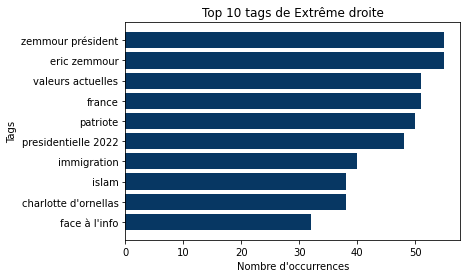

In [15]:
# Année 2022
subdtf_videos = videos_candidats_2022_full
videos_xd_22, videos_xg_22, videos_d_22, videos_g_22, videos_c_22, videos_v_22, videos_reste_22 = un_dtf_par_courant(subdtf=subdtf_videos)
top_tags = liste_top_tags_de_chaines (dtfv = videos_xd_22, colonne = 'courant', valeur = 'Extrême droite', top = 10, titre = '', color = "#073763", liste_exceptions = ['Debout La France', 'Nicolas Dupont-Aignan', 'zemmour', 'zemmour 2022', 'Z00Z'])
# Dump des fichiers
dump_tags_json(toptags=top_tags, nomfichier= dossier_output + toptagsfolder_json + "top_tags_extreme_droite_2022.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_extreme_droite_2022.csv')

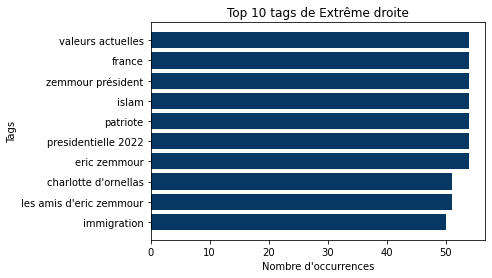

In [16]:
# Année 2021
subdtf_videos = videos_candidats_2021
videos_xd_21, videos_xg_21, videos_d_21, videos_g_21, videos_c_21, videos_v_21, videos_reste_21 = un_dtf_par_courant(subdtf=subdtf_videos)
top_tags = liste_top_tags_de_chaines (dtfv = videos_xd_21, colonne = 'courant', valeur = 'Extrême droite', top = 10, titre = '', color = "#073763", liste_exceptions = ['Debout La France', 'Nicolas Dupont-Aignan', 'zemmour', 'zemmour 2022', 'Z00Z'])
# Dump des fichiers
dump_tags_json(toptags=top_tags, nomfichier= dossier_output + toptagsfolder_json + "top_tags_extreme_droite_2021.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_extreme_droite_2021.csv')

### 3.2.2. Extrême gauche

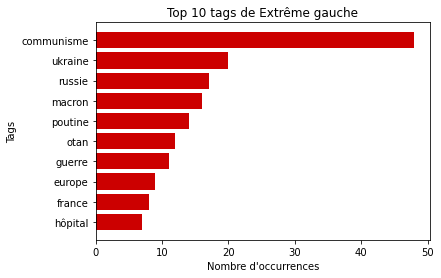

In [17]:
# Année 2022
top_tags = liste_top_tags_de_chaines (dtfv = videos_xg_22, colonne = 'courant', valeur = 'Extrême gauche', top = 10, titre = '', color = "#cc0000", liste_exceptions = ['Nathalie', 'Lutte', 'ouvrière', 'Arthaud', 'LO', 'mélenchon'])
dump_tags_json(toptags=top_tags, nomfichier= dossier_output + toptagsfolder_json + "top_tags_extreme_gauche_2022.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_extreme_gauche_2022.csv')

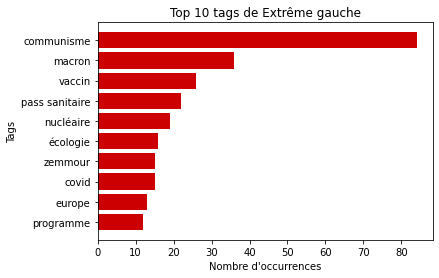

In [18]:
# Année 2021
top_tags = liste_top_tags_de_chaines (dtfv = videos_xg_21, colonne = 'courant', valeur = 'Extrême gauche', top = 10, titre = '', color = "#cc0000", liste_exceptions = ['Nathalie', 'Lutte', 'ouvrière', 'Arthaud', 'LO', 'mélenchon'])
dump_tags_json(toptags=top_tags, nomfichier= dossier_output + toptagsfolder_json + "top_tags_extreme_gauche_2021.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_extreme_gauche_2021.csv')

### 3.2.3. Droite

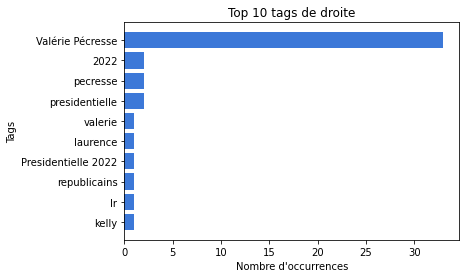

In [19]:
# Année 2022
top_tags = liste_top_tags_de_chaines (dtfv = videos_d_22, colonne = 'courant', valeur = 'droite', top = 10, titre = '', color = "#3c78d8")
dump_tags_json(toptags=top_tags, nomfichier=dossier_output + toptagsfolder_json + "top_tags_droite_2022.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_droite_2022.csv')

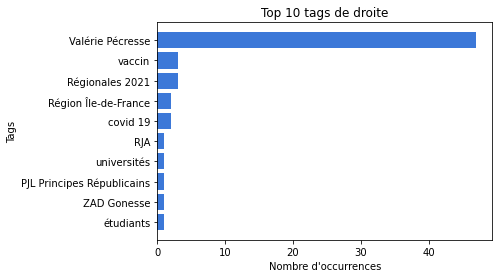

In [20]:
# Année 2021
top_tags = liste_top_tags_de_chaines (dtfv = videos_d_21, colonne = 'courant', valeur = 'droite', top = 10, titre = '', color = "#3c78d8")
dump_tags_json(toptags=top_tags, nomfichier=dossier_output + toptagsfolder_json + "top_tags_droite_2021.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_droite_2021.csv')

### 3.2.4. Gauche

In [21]:
# Année 2022
top_tags = liste_top_tags_de_chaines (dtfv = videos_g_22, colonne = 'courant', valeur = 'gauche', top = 10, titre = '', color = "#e6a3bf")
dump_tags_json(toptags=top_tags, nomfichier=dossier_output + toptagsfolder_json + "top_tags_gauche_2022.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_gauche_2022.csv')

Aucun tags trouvés sur les vidéos sélectionnées


In [22]:
# Année 2021
top_tags = liste_top_tags_de_chaines (dtfv = videos_g_21, colonne = 'courant', valeur = 'gauche', top = 10, titre = '', color = "#e6a3bf")
dump_tags_json(toptags=top_tags, nomfichier=dossier_output + toptagsfolder_json + "top_tags_gauche_2021.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_gauche_2021.csv')

Aucun tags trouvés sur les vidéos sélectionnées


### 3.2.5. Verts

impossible de dropper Les Verts


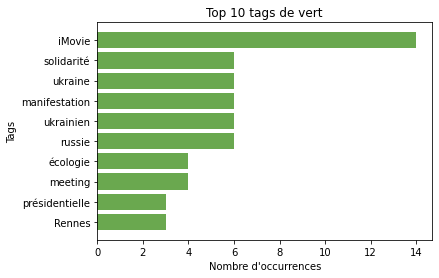

In [23]:
# Année 2022
top_tags = liste_top_tags_de_chaines (dtfv = videos_v_22, colonne = 'courant', valeur = 'vert', top = 10, titre = '', color = "#6aa84f", liste_exceptions=['jadot 2022', 'yannick jadot', 'Les Verts'])
dump_tags_json(toptags=top_tags, nomfichier=dossier_output + toptagsfolder_json + "top_tags_verts_2022.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_verts_2022.csv')

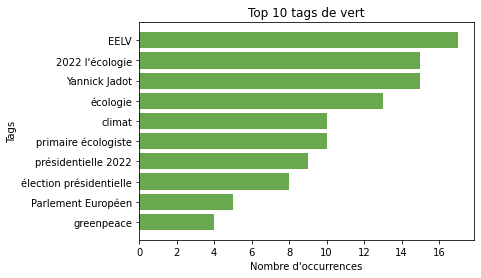

In [24]:
# Année 2021
# On va filtrer pas mal de tags, car il y en a plusieurs qui ne sont pas très parlant
top_tags = liste_top_tags_de_chaines (dtfv = videos_v_21, colonne = 'courant', valeur = 'vert', top = 10, titre = '', color = "#6aa84f", liste_exceptions=['jadot 2022', 'yannick jadot', 'Europe Écologie Les Verts', 'Les Verts', '2022lecologie.fr', 'candidature écologie', 'Yannick Jadot 2022', 'Q&A', 'écologistes', 'Jadot2022', 'Jadot 2022'])
dump_tags_json(toptags=top_tags, nomfichier=dossier_output + toptagsfolder_json + "top_tags_verts_2021.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_verts_2021.csv')

#### Bonus : Dumper tous les tags des verts

On a remarqué que certains tags des verts étaient très surprenants. On a donc fait une fonction qui permet de récupérer ces tags

In [25]:
#---------------------------------------------------------------------------------------------
# Instaloader charge les hashtag sous forme de string. Cette fonction permet de creer
# un dataframe chaque hashtag a une ligne associe a son post et a son organisme
#---------------------------------------------------------------------------------------------
def create_hashtagliste_dataframe(subdtf) :
    output_list = []
    initial_dtf = subdtf
    for ind in initial_dtf.index :
        compte = initial_dtf['titreVideo'][ind]
        date_post = initial_dtf['dateVideo'][ind]
        str_hashtags = initial_dtf['liste_tags'][ind]
        nb_likes = initial_dtf['likesVideo'][ind]
        if str_hashtags != '[]' :
            # res = str_hashtags.strip("][ ").split(',')
            for i in range(len(str_hashtags)) :
                res_clean = str_hashtags[i].replace(" ", "")
                res_clean = res_clean.replace("'", "")
                res_clean = "#" + res_clean
                output_list.append([compte, date_post, res_clean, nb_likes])
        else :
            output_list.append([compte, date_post, "None"])
    output_dtf = pd.DataFrame(output_list, columns=['NomO', 'dateP', 'hashtag', 'nbLikes'])
    return output_dtf

hash_v = create_hashtagliste_dataframe(videos_v_22)
hash_v.head(2)


,NomO,dateP,hashtag,nbLikes
0,YANNICK JADOT FACE À BFM TV,2022-02-16 12:04:04,#jadot2022,244
1,YANNICK JADOT FACE À BFM TV,2022-02-16 12:04:04,#yannickjadot,244


### 3.2.6. Majorité

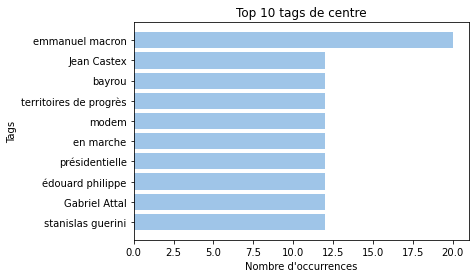

In [26]:
# Année 2022
top_tags = liste_top_tags_de_chaines (dtfv = videos_c_22, colonne = 'courant', valeur = 'centre', top = 10, titre = '', color = "#9fc5e8", liste_exceptions=['macron'])
dump_tags_json(toptags=top_tags, nomfichier=dossier_output + toptagsfolder_json + "top_tags_majorite_2022.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_majorite_2022.csv')

In [27]:
# Année 2021
# On sait que ce sera vide, vu que la chaîne a commencé à exister en 2022, mais nous agissons comme des machines
top_tags = liste_top_tags_de_chaines (dtfv = videos_c_21, colonne = 'courant', valeur = 'centre', top = 10, titre = '', color = "#9fc5e8")
dump_tags_json(toptags=top_tags, nomfichier=dossier_output + toptagsfolder_json + "top_tags_majorite_2021.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_majorite_2021.csv')

Aucun tags trouvés sur les vidéos sélectionnées


# Préparation des transcripts pour notre traitement suivant

Ici, on liste les vidéos pour lesquelles on va vouloir récupérer le transcript.

Dans notre cas, on souhaite ne travailler pour l'instant que sur le mois de février.

In [28]:
date_segment = {"datemin" : datetime.datetime(2022,2,1,0,0,0), "datemax" : datetime.datetime(2022,3,1,0,0,0)}
video_du_mois = videos_candidats_2022[videos_candidats_2022['dateVideo'] > date_segment["datemin"]]
video_du_mois = video_du_mois[video_du_mois["dateVideo"] < date_segment["datemax"]]
video_du_mois.shape[0]

231

In [29]:
video_du_mois.to_csv('./temp_files/liste_de_video_pour_transcript_analyse.csv')

# Extraction de quelques stats globales pour le bandeau défilant

In [30]:
video_du_mois.vuesVideo.sum()

17853409

In [31]:
video_du_mois.shape[0]

231